In [1]:
import torch
import numpy as np
import ase.io
import tqdm

import sys
sys.path.append('../code/')
from code_pytorch import *
from utilities import *
from miscellaneous import ClebschGordan
torch.set_default_dtype(torch.float32)
from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt
import time
torch.set_num_threads(1)
from rascal.representations import SphericalInvariants
from rascal.models import Kernel, train_gap_model
from rascal.utils import FPSFilter

In [2]:
HARTREE_TO_EV = 27.211386245988
FORCE_FACTOR = 51.42208619083232
LAMBDA_MAX = 5
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 10,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO',
}

train_subset = '0:10000'
test_subset = '10000:11000'

METHANE_PATH = '../methane.extxyz'
clebsch = ClebschGordan(LAMBDA_MAX)
N_MEASUREMENTS = 1
GRID = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000]

In [3]:
train_structures =  process_structures(ase.io.read(METHANE_PATH , index=train_subset))
test_structures =  process_structures(ase.io.read(METHANE_PATH , index=test_subset))

all_species = get_all_species(train_structures + test_structures)

train_coefficients = get_coefs(train_structures, HYPERS, all_species) 
test_coefficients = get_coefs(test_structures, HYPERS, all_species) 
L2_mean = get_L2_mean(train_coefficients)

for key in train_coefficients.keys():
    train_coefficients[key] /= torch.sqrt(L2_mean)
    test_coefficients[key] /= torch.sqrt(L2_mean)

train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV

mean_e = np.mean(train_energies)
train_energies = train_energies - mean_e
test_energies = test_energies - mean_e

test_forces = [structure.arrays["forces"] for structure in test_structures]
test_forces = np.concatenate(test_forces, axis = 0) * FORCE_FACTOR

coef_der_test, central_indices_test, derivative_indices_test = \
get_coef_ders(test_structures, HYPERS, all_species)


for key in coef_der_test.keys():
    coef_der_test[key] = coef_der_test[key] / torch.sqrt(L2_mean)

n_atoms_train = len(get_structural_indices(train_structures))
np.random.seed(0)
sparse_indices = np.random.permutation(n_atoms_train)



In [4]:
def get_kernel(features, sparse_points):
    features = features / torch.sqrt(torch.sum(features * features, dim = 1))[:, None]
    #print("features: ", features.shape)
    return torch.matmul(features, torch.transpose(sparse_points, 0, 1)) ** 2

class KernelSingle(torch.nn.Module):
    def __init__(self, clebsch, sparse_points):
        super(KernelSingle, self).__init__()
        self.clebsch_combining = ClebschCombining(clebsch, 0)
        n_sparse = sparse_points.shape[0]
        sparse_points = sparse_points / torch.sqrt(torch.sum(sparse_points * sparse_points, dim = 1))[:, None]
        self.register_parameter('sparse_points', torch.nn.Parameter(sparse_points))
        self.linear = torch.nn.Linear(n_sparse, 1, bias = False)
        
    def forward(self, X):
        ps = self.clebsch_combining(X, X)['0'].squeeze()
        kernel_values = get_kernel(ps, self.sparse_points)
        return {'energies' : self.linear(kernel_values)}
    
def get_mae(first, second):
    return np.mean(np.abs(first - second))

def get_rmse(first, second):
    return np.sqrt(np.mean((first - second) ** 2))

def measure_performance_torch(model, device):
    
   
        
    test_struc_ind = get_structural_indices(test_structures)
    times_energies = []
    times_energies_from_sph = []
    for _ in range(N_MEASUREMENTS):
        begin = time.time()
        test_coefficients = get_coefs(test_structures, HYPERS, all_species)
        for key in test_coefficients.keys():
            test_coefficients[key] = test_coefficients[key].to(device) / torch.sqrt(L2_mean)
        test_struc_indices = get_structural_indices(test_structures)
        begin_from_sph = time.time()
        energies_predictions = model(test_coefficients, structural_indices = test_struc_ind)['energies']
        times_energies_from_sph.append(time.time() - begin_from_sph)
        times_energies.append(time.time() - begin)
    
    energies_predictions = energies_predictions.data.cpu().numpy()
    mae_energies = get_mae(energies_predictions, test_energies)
    rmse_energies = get_rmse(energies_predictions, test_energies)
    
    for key in test_coefficients.keys():
        test_coefficients[key].requires_grad = True
        
    times_forces = []
    times_forces_from_sph = []
    for _ in range(N_MEASUREMENTS):
        begin = time.time()
        
        test_coefficients = get_coefs(test_structures, HYPERS, all_species)
        for key in test_coefficients.keys():
            test_coefficients[key] = test_coefficients[key].to(device) / torch.sqrt(L2_mean)
            test_coefficients[key].requires_grad = True
        
        test_struc_indices = get_structural_indices(test_structures)
        
        coef_der_test, central_indices_test, derivative_indices_test = \
        get_coef_ders(test_structures, HYPERS, all_species)
        for key in coef_der_test.keys():
            coef_der_test[key] = coef_der_test[key].to(device) / torch.sqrt(L2_mean)
        begin_from_sph = time.time()
        forces_predictions = model.get_forces(coef_der_test, central_indices_test, derivative_indices_test,
                                              test_coefficients, structural_indices = test_struc_ind) 
        times_forces_from_sph.append(time.time() - begin_from_sph)                               
        times_forces.append(time.time() - begin)
        
    forces_predictions = forces_predictions.data.cpu().numpy()
    mae_forces = get_mae(forces_predictions, test_forces)
    rmse_forces = get_rmse(forces_predictions, test_forces)
    result = {'times_energies' : times_energies,
              'times_energies_from_sph' : times_energies_from_sph,
              'times_forces' : times_forces,
              'times_forces_from_sph' : times_forces_from_sph,
              'mae_energies' : mae_energies,
              'rmse_energies' : rmse_energies,
              'mae_forces' : mae_forces,
              'rmse_forces' : rmse_forces}
    
    return result

def get_skm_torch(n_sparse, device):
    #print(device)
   
    
    block = ClebschCombining(clebsch.precomputed_, 0)
    train_ps = block(train_coefficients, train_coefficients)['0'].squeeze()
    test_ps = block(test_coefficients, test_coefficients)['0'].squeeze()

    
    sparse_points = train_ps[sparse_indices[0:n_sparse]]

    train_kernel = get_kernel(train_ps, sparse_points)
    test_kernel = get_kernel(test_ps, sparse_points)
    #print([0:5])
   
    accumulator = Accumulator()
    
    train_kernel = accumulator({"kernel": train_kernel}, get_structural_indices(train_structures))['kernel']
    test_kernel = accumulator({"kernel": test_kernel}, get_structural_indices(test_structures))['kernel']
    
    #print(train_kernel[0:5])
    regr = Ridge(alpha = 1e-10, fit_intercept = False)
    regr.fit(train_kernel.data.cpu().numpy(), train_energies)
    #print(regr.coef_.dtype)
    block = KernelSingle(clebsch.precomputed_, sparse_points).to(device)
    with torch.no_grad():
        block.linear.weight = torch.nn.Parameter(torch.from_numpy(regr.coef_).\
                                                 type(torch.get_default_dtype()).to(device))
    model = Atomistic(block).to(device)
    model = model.train(False)
    return model
    

In [5]:
def get_skm_rascal(n_sparse, destination):
    hypers_ps = copy.deepcopy(HYPERS)
    hypers_ps['soap_type'] = 'PowerSpectrum'
    hypers_ps['normalize'] = True
    if (destination == "forces") :
        hypers_ps['compute_gradients'] = True
    
    soap = SphericalInvariants(**hypers_ps)
    train_managers = soap.transform(train_structures)
    
    n_sparse = {1:int(n_sparse / 2), 6:int(n_sparse / 2)}
    compressor = FPSFilter(soap, n_sparse, act_on='sample per species')
    X_sparse = compressor.select_and_filter(train_managers)
    
    zeta = 2
    kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
    KNM = kernel(train_managers, X_sparse)
    #KNM_down = kernel(train_managers, X_sparse)
    #KNM = np.vstack([KNM, KNM_down])
    model = train_gap_model(kernel, train_structures, KNM, X_sparse, train_energies, {1: 0.0, 6: 0.0}, 
                            lambdas = [1.0, 0.0], jitter=1e-13)
    return model

def measure_performance_rascal(model, task):
    if task == "energies":
        hypers_ps = copy.deepcopy(HYPERS)
        hypers_ps['soap_type'] = 'PowerSpectrum'
        hypers_ps['normalize'] = True
        soap = SphericalInvariants(**hypers_ps)

        times_energies = []
        for _ in range(N_MEASUREMENTS):
            begin = time.time()
            managers_test = soap.transform(test_structures)
            predictions_energies = model.predict(managers_test)
            times_energies.append(time.time() - begin)
        mae_energies = get_mae(predictions_energies, test_energies)
        rmse_energies = get_rmse(predictions_energies, test_energies)
        return {'mae_energies' : mae_energies,
            'rmse_energies' : rmse_energies,
            'times_energies' : times_energies}
    
    if task == "forces":
        hypers_ps_grad = copy.deepcopy(HYPERS)
        hypers_ps_grad['soap_type'] = 'PowerSpectrum'
        hypers_ps_grad['normalize'] = True
        hypers_ps_grad['compute_gradients'] = True
        soap = SphericalInvariants(**hypers_ps_grad)

        times_forces = []
        for _ in range(N_MEASUREMENTS):
            begin = time.time()
            managers_test = soap.transform(test_structures)
            predictions_forces = model.predict_forces(managers_test)
            times_forces.append(time.time() - begin)
        mae_forces = get_mae(predictions_forces, test_forces)
        rmse_forces = get_rmse(predictions_forces, test_forces)
        return { 'mae_forces' : mae_forces,
                'rmse_forces' : rmse_forces,
                'times_forces' : times_forces}


In [6]:
np.random.seed(0)
rascal_E_times = []
for n_sparse in GRID:
    model = get_skm_rascal(n_sparse, "energies")
    statistics = measure_performance_rascal(model, "energies")
    rascal_E_times.append(np.mean(statistics["times_energies"]))
    

The number of pseudo points selected by central atom species is: {1: 5, 6: 5}
Selecting species: 1
Selecting species: 6
The number of pseudo points selected by central atom species is: {1: 12, 6: 12}
Selecting species: 1
Selecting species: 6
The number of pseudo points selected by central atom species is: {1: 25, 6: 25}
Selecting species: 1
Selecting species: 6
The number of pseudo points selected by central atom species is: {1: 50, 6: 50}
Selecting species: 1
Selecting species: 6
The number of pseudo points selected by central atom species is: {1: 125, 6: 125}
Selecting species: 1
Selecting species: 6
The number of pseudo points selected by central atom species is: {1: 250, 6: 250}
Selecting species: 1
Selecting species: 6
The number of pseudo points selected by central atom species is: {1: 500, 6: 500}
Selecting species: 1
Selecting species: 6
The number of pseudo points selected by central atom species is: {1: 1250, 6: 1250}
Selecting species: 1
Selecting species: 6
The number of ps

In [7]:
np.random.seed(0)
rascal_F_times = []
for n_sparse in GRID:
    model = get_skm_rascal(n_sparse, "forces")
    statistics = measure_performance_rascal(model, "forces")
    rascal_F_times.append(np.mean(statistics["times_forces"]))   

The number of pseudo points selected by central atom species is: {1: 5, 6: 5}
Selecting species: 1
Selecting species: 6
The number of pseudo points selected by central atom species is: {1: 12, 6: 12}
Selecting species: 1
Selecting species: 6
The number of pseudo points selected by central atom species is: {1: 25, 6: 25}
Selecting species: 1
Selecting species: 6
The number of pseudo points selected by central atom species is: {1: 50, 6: 50}
Selecting species: 1
Selecting species: 6
The number of pseudo points selected by central atom species is: {1: 125, 6: 125}
Selecting species: 1
Selecting species: 6
The number of pseudo points selected by central atom species is: {1: 250, 6: 250}
Selecting species: 1
Selecting species: 6
The number of pseudo points selected by central atom species is: {1: 500, 6: 500}
Selecting species: 1
Selecting species: 6
The number of pseudo points selected by central atom species is: {1: 1250, 6: 1250}
Selecting species: 1
Selecting species: 6
The number of ps

In [8]:
np.random.seed(0)
torch_cpu_E_times = []
torch_cpu_F_times = []
torch_cpu_E_times_from_sph = []
torch_cpu_F_times_from_sph = []
for n_sparse in tqdm.tqdm(GRID):
    model = get_skm_torch(n_sparse, 'cpu')
    statistics = measure_performance_torch(model, 'cpu')
    torch_cpu_E_times.append(np.mean(statistics["times_energies"]))
    torch_cpu_F_times.append(np.mean(statistics["times_forces"]))
    torch_cpu_E_times_from_sph.append(np.mean(statistics["times_energies_from_sph"]))
    torch_cpu_F_times_from_sph.append(np.mean(statistics["times_forces_from_sph"]))
    
    

  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.90963e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
100%|██████████| 9/9 [02:22<00:00, 15.81s/it]


In [9]:
np.random.seed(0)
torch_cuda_E_times = []
torch_cuda_F_times = []
torch_cuda_E_times_from_sph = []
torch_cuda_F_times_from_sph = []
for n_sparse in tqdm.tqdm(GRID):
    model = get_skm_torch(n_sparse, 'cuda')
    model = model.cuda()
    statistics = measure_performance_torch(model, 'cuda')
    torch_cuda_E_times.append(np.mean(statistics["times_energies"]))
    torch_cuda_F_times.append(np.mean(statistics["times_forces"]))
    torch_cuda_E_times_from_sph.append(np.mean(statistics["times_energies_from_sph"]))
    torch_cuda_F_times_from_sph.append(np.mean(statistics["times_forces_from_sph"]))
    

  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.90963e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
100%|██████████| 9/9 [01:52<00:00, 12.47s/it]


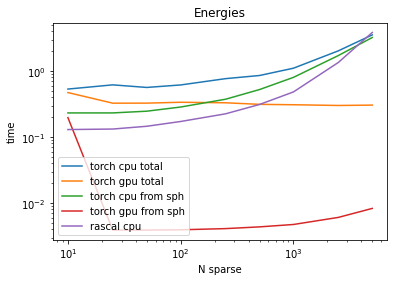

In [12]:
plt.plot(GRID, torch_cpu_E_times, label = 'torch cpu total')
plt.plot(GRID, torch_cuda_E_times, label = 'torch gpu total')
plt.plot(GRID, torch_cpu_E_times_from_sph, label = 'torch cpu from sph')
plt.plot(GRID, torch_cuda_E_times_from_sph, label = 'torch gpu from sph')

plt.plot(GRID, rascal_E_times, label = 'rascal cpu')
plt.xlabel("N sparse")
plt.ylabel("time")
plt.xscale('log')
plt.yscale("log")
plt.title("Energies")
plt.legend()
plt.savefig("energies_bench_torch.float32.pdf", dpi = 200, bbox_inches = 'tight')
plt.show()

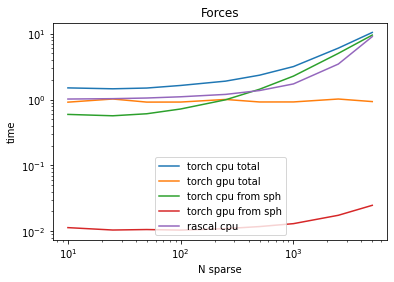

In [13]:
plt.plot(GRID, torch_cpu_F_times, label = 'torch cpu total')
plt.plot(GRID, torch_cuda_F_times, label = 'torch gpu total')
plt.plot(GRID, torch_cpu_F_times_from_sph, label = 'torch cpu from sph')
plt.plot(GRID, torch_cuda_F_times_from_sph, label = 'torch gpu from sph')
plt.plot(GRID, rascal_F_times, label = 'rascal cpu')
plt.xlabel("N sparse")
plt.ylabel("time")
plt.xscale('log')
plt.yscale("log")
plt.title("Forces")
plt.legend()
plt.savefig("forces_bench_torch.float32.pdf", dpi = 200, bbox_inches = 'tight')
plt.show()